# Computing structure functions
As in the paper, we define
$$\bar{S}_p(h)=\int_{L^1(D,P)}\int_{D} |u(x+h)-u(x)|^p \; dx\;d\mu_t(u)$$

Likewise we define
$$\bar{S}^2(h_1,h_2)=\int_{L^1(D,P)}\int_{D} (u(x)-u(x+h_1))(u-u(x+h_2))^2 \; dx\;d\mu_t(u)$$

# Needed imports

In [1]:
import sys
sys.path.append('../alsvinn_build_folder/python')
sys.path.append('../python')
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
import matplotlib2tikz
import scipy.integrate
import alsvinn
import plot_info
import os
import sys
import shutil
from estimate_variance_decay import plot_variance_decay

from IPython.core.display import display, HTML


# Utility functions

In [2]:

def upscale(d,N):
    """
    Upscales the data to the given resolution
    """
    while d.shape[0] < N:
        d = np.repeat(d,2,0)
    return d


    
def headline1(name):
    """
    Displays a nice level 1 heading
    """
    display(HTML("<h1>%s</h1>" % name))
    
def headline2(name):
    """
    Displays a nice level 2 heading
    """
    display(HTML("<h2>%s</h2>" % name))
    
    
        
def headline3(name):
    """
    Displays a nice level 2 heading
    """
    display(HTML("<h3>%s</h3>" % name))
    
def estimateConvergenceRates(work, errors, color='green'):
    """
    Estimates the rate of convergence (error vs work)
    """
    
    # Just be sure we are working with numpy arrays
    work = np.array(work)
    errors = np.array(errors)
    
    # estimate polynomial
    poly = np.polyfit(np.log(work), np.log(errors),1)
    
    # Plot
    plt.loglog(work, np.exp(poly[1])*work**poly[0],
               '--',
               color=color,
               label='$\\mathcal{O}(\\mathrm{Work}^{%.2f})$' % poly[0])

# MLMC speedups

In [21]:
def compute_mean_speedup(basename, name):
    def computer(resolution):
        samples = []
        
        with netCDF4.Dataset(basename % resolution) as f:
            sample = 0
            while True:
                try:
                    samples.append(f.variables[f'sample_{sample}_u'][:,0,0])
                    sample += 1
                except:
                    return np.array(samples)
                
                
    def computer_m2(resolution):
        return computer(resolution)**2
    
    resolutions = [128,256,512,1024, 2048,4096,  2*4096, 4*4096]
    plot_variance_decay(name, resolutions, computer, 2, "u^{{{N}}}")
    plt.show()
    plot_variance_decay(name, resolutions, computer_m2, 2, "(u^{{{N}}})^2")
    plt.show()
    
def compute_structure_speedup(basename, name):
    
    for p in [1,2,3]:
        def computer(resolution):
            
            H = np.linspace(0, 32./1024., int(resolution*32/1024))
            samples = []
            
    
            sample = 0
            filename = basename % resolution
            while True:
                try:
                    samples.append(structure(filename, sample+1, H, resolution, p, sample))
                    sample += 1
                except:
                    return np.array(samples)
        
        resolutions = [256,512,1024, 2048, 4096]
        plot_variance_decay(name, resolutions, computer, 2, "\\bar{{S}}^{{" + str(p) +"}}_h(u^{{{N}}})")
        plt.show()
        
        
def compute_structure_cube_speedup(basename, name):
    
    for p in [1,2,3]:
        def computer(resolution):
            
            H = np.linspace(0, 32./1024., int(resolution*32/1024))
            samples = []
            
    
            sample = 0
            filename = basename % resolution
            while True:
                try:
                    samples.append(structure_cube(filename, sample+1, H, resolution, p, sample))
                    sample += 1
                except:
                    return np.array(samples)
        
        resolutions = [256,512,1024, 2048, 4096]
        plot_variance_decay(name, resolutions, computer, 2, "S^{{" + str(p) +"}}_h(u^{{{N}}})")
        plt.show()

# Structure computations

In [4]:
def structure(filename, samples, H, targetResolution, p, sampleStart=0):
    structure = np.zeros_like(H)
    Hs = list(range(0,len(H)))
    maxH  = max(Hs)
    with netCDF4.Dataset(filename) as f:
        for k in range(sampleStart, samples):
            d = f.variables[f'sample_{k}_u'][:,0,0]
            
            d=upscale(d,targetResolution)
            
            
            # for the Neumann boundary conditions
            d_extended = d[-1] * np.ones(targetResolution + Hs[-1])
            d_extended[:targetResolution] = d
            
            for h in Hs[1:]:
                structure[h] += np.sum(abs(d_extended[h:]-d_extended[:-h])**p/targetResolution)
                
    structure /= samples
    return structure

def structure_cube(filename, samples, H, targetResolution, p, sampleStart=0):
    structure = np.zeros_like(H)
    Hs = list(range(0,len(H)))
    maxH  = max(Hs)
    with netCDF4.Dataset(filename) as f:
        for k in range(sampleStart, samples):
            d = f.variables[f'sample_{k}_u'][:,0,0]
            
            d=upscale(d,targetResolution)
            
            
            # for the Neumann boundary conditions
            d_extended = d[-1] * np.ones(targetResolution + 2*Hs[-1])
            d_extended[:Hs[-1]] = d[0] * np.ones_like(d_extended[:Hs[-1]])
            d_extended[Hs[-1]:Hs[-1]+targetResolution] = d
            
            for h in Hs[1:]:
                for m in range(1, h+1):
                    structure[h] += \
                        (np.sum(abs(d_extended[Hs[-1]+m:]-d_extended[Hs[-1]:-m])**p/targetResolution) \
                        + np.sum(abs(d_extended[Hs[-1]-m:-2*m]-d_extended[Hs[-1]:-m])**p/targetResolution))/(2*h)

    structure /= samples
    return structure

def structure_single_point(filename, samples, H, targetResolution, p, x):
    structure = np.zeros_like(H)
    Hs = range(0,len(H))
    maxH  = max(Hs)
    xi = int(targetResolution*x)
    with netCDF4.Dataset(filename) as f:
        for k in range(samples):
            d = f.variables[f'sample_{k}_u'][:,0,0]
            
            d=upscale(d,targetResolution)
            
            for h in Hs:
                structure[h] += abs(d[xi+h]-d[xi])**p
    structure /= samples
    return structure

# Two point structure functions

In [5]:
def structure2pt(filename, samples, H, targetResolution):
    structure = np.zeros((len(H),len(H)))
    Hs = range(0,len(H))
    maxH = max(Hs)
    with netCDF4.Dataset(filename) as f:
        for k in range(samples):
            d = f.variables[f'sample_{k}_u'][:,0,0]
            
            d=upscale(d,targetResolution)
            
            for h1 in Hs:
                for h2 in Hs:
                    for x in range(0, targetResolution-maxH):
                        structure[h1,h2] += (d[x+h1]-d[x])**2*(d[x+h2]-d[x])/targetResolution
    structure /= samples
    return structure

# MLMC

In [6]:
def make_resolutions(resolutions, nr, basename):
    """
    Makes a list of files to be used for MLMC
    """
    resolutions_mlmc = {}
    L = min(nr, 5)
    for l in range(0,L+1):
        resolutions_mlmc[l] = basename % resolutions[nr-L+l]
    return resolutions_mlmc

def mlmc(fNames, convergenceRate, H, p, targetResolution):
    """
    Computes the one point structure functions using MLMC
    """
    L = max(fNames.keys())
    s = np.zeros((len(H)))
    runtime = 0
    for level in fNames.keys():
        if level == 0:
            s += structure(fNames[level],getResolution(fNames[L]),H, targetResolution, p)
            runtime += getResolution(fNames[level])**2*getResolution(fNames[L])
        else:
            samples = int(16*2**(2*convergenceRate*(L-level)))
            structureFine = structure(fNames[level],samples,H,targetResolution, p)
            structureCoarse = structure(fNames[level-1], samples,H,targetResolution, p)
            s += structureFine - structureCoarse
            
            runtime += (getResolution(fNames[level])**2+getResolution(fNames[level])**2)*samples
    return runtime, s

def mlmc2pt(fNames, convergenceRate, H, targetResolution):
    L = max(fNames.keys())
    s = np.zeros((len(H), len(H)))
    runtime = 0
    for level in fNames.keys():
        if level == 0:
            s += structure2pt(fNames[level],getResolution(fNames[L]),H, targetResolution)
            runtime += getResolution(fNames[level])**2*getResolution(fNames[L])
        else:
            samples = int(16*2**(2*convergenceRate*(L-level)))
            structureFine = structure2pt(fNames[level],samples,H,targetResolution)
            structureCoarse = structure2pt(fNames[level-1], samples,H,targetResolution)
            s += structureFine - structureCoarse
            
            runtime += (getResolution(fNames[level])**2+getResolution(fNames[level])**2)*samples
    return runtime, s


# Convergence study

## 1 pt convergence

In [7]:
def makeConvergenceStudy(basename, name, p, mlmcConvergenceRate=0.5, exactSolution = None):
    
    
    targetResolution = 4096
    H = np.linspace(0,32.0/1024, int(32.0/1024*targetResolution))
    
    if exactSolution is None:
        referenceSolution = structure(basename % targetResolution, targetResolution, H, targetResolution, p)
    else:
        referenceSolution = exactSolution(H)
    
    
    resolutions = [128,256,512,1024, 2048]
    errors = []
    errors_mlmc = []
    runtimes_mlmc = []
    for (nr, resolution) in enumerate(resolutions):
        
       
        s = (structure(basename % resolution, resolution, H, targetResolution, p))**(1.0/p)
        
        
        errors.append(sum(abs(s-referenceSolution**(1.0/p)))/len(H))
        
        runtime_mlmc, smlmc = mlmc(make_resolutions(resolutions, nr, basename), mlmcConvergenceRate, 
                                   H,p, targetResolution)
        smlmc = smlmc**(1.0/p)
        runtimes_mlmc.append(runtime_mlmc)
        errors_mlmc.append(sum(abs(smlmc-referenceSolution**(1.0/p)))/len(H))
    
    
        plt.figure(2)
        ref = plt.loglog(H, s, label=f'$N={resolution}$')
        poly = np.polyfit(np.log(H[1:]), np.log(s[1:]), 1)
        plt.loglog(H, np.exp(poly[1])*H**poly[0], '--', color=ref[0].get_color(),
                  label=f'${np.exp(poly[1]):.3f}r^{{{poly[0]:.2f}}}$',
                  basex=2, basey=2)
        plt.xlabel('$r$')
        plt.ylabel(f'$S^{{{p}}}_r(\\mu^{{N}})$')
        plt.title(f'Scaling $p={p}$')
    
    print(errors)
    print(errors_mlmc)
    runtimes = [r**3 for r in resolutions ]
    plt.figure(0)
    
    plot_ref = plt.loglog(runtimes, errors,'-o',label='Monte-Carlo, $p=%d$' % p)
    estimateConvergenceRates(runtimes, errors, color=plot_ref[0].get_color())
    plot_ref = plt.loglog(runtimes_mlmc, errors_mlmc,'-o',label='MLMC, $p=%d$' % p)
    estimateConvergenceRates(runtimes_mlmc, errors_mlmc, color=plot_ref[0].get_color())
    plt.gca().set_xscale('log', basex=2)
    plt.gca().set_yscale('log', basey=2)
    plt.figure(1)
    
    plot_ref = plt.loglog(runtimes, errors,'-o',label='Monte-Carlo, $p=%d$' % p)
    estimateConvergenceRates(runtimes, errors, color=plot_ref[0].get_color())
    plt.gca().set_xscale('log', basex=2)
    plt.gca().set_yscale('log', basey=2)
    
    
def makeConvergenceStudyCube(basename, name, p, mlmcConvergenceRate=0.5):
    targetResolution = 4096
    H = np.linspace(0,32.0/1024, int(32.0/1024*targetResolution))
    
    referenceSolution = structure_cube(basename % targetResolution, targetResolution, H, targetResolution, p)
   
    
    resolutions = [128,256,512,1024, 2048]
    errors = []
    errors_mlmc = []
    runtimes_mlmc = []
    for (nr, resolution) in enumerate(resolutions):
       
        s = (structure_cube(basename % resolution, resolution, H, targetResolution, p))**(1.0/p)
        
        
        errors.append(sum(abs(s-referenceSolution**(1.0/p)))/len(H))
        
        runtime_mlmc, smlmc = mlmc(make_resolutions(resolutions, nr, basename), mlmcConvergenceRate, 
                                   H,p, targetResolution)
        smlmc = smlmc**(1.0/p)
        runtimes_mlmc.append(runtime_mlmc)
        errors_mlmc.append(sum(abs(smlmc-referenceSolution**(1.0/p)))/len(H))
        
        plt.figure(2)
        ref = plt.loglog(H, s, label=f'$N={resolution}$')
        poly = np.polyfit(np.log(H[1:]), np.log(s[1:]), 1)
        plt.loglog(H, np.exp(poly[1])*H**poly[0], '--', color=ref[0].get_color(),
                  label=f'${np.exp(poly[1]):.3f}r^{{{poly[0]:.2f}}}$',
                  basex=2, basey=2)
        plt.xlabel('$r$')
        if p > 1:
            plt.ylabel(f'$S^{{{p}}}_r(\\mu^{{N}})^{{1/{p}}}$')
        else:
            plt.ylabel(f'$S^{{{p}}}_r(\\mu^{{N}})$')
        plt.title(f'(cube structure function) Scaling $p={p}$')
        
    print(errors)
    print(errors_mlmc)
    runtimes = [r**3 for r in resolutions ]
    plt.figure(0)
    
    plot_ref = plt.loglog(runtimes, errors,'-o',label='Monte-Carlo, $p=%d$' % p)
    estimateConvergenceRates(runtimes, errors, color=plot_ref[0].get_color())
    plot_ref = plt.loglog(runtimes_mlmc, errors_mlmc,'-o',label='MLMC, $p=%d$' % p)
    estimateConvergenceRates(runtimes_mlmc, errors_mlmc, color=plot_ref[0].get_color())
    plt.gca().set_xscale('log', basex=2)
    plt.gca().set_yscale('log', basey=2)
    plt.figure(1)
    
    plot_ref = plt.loglog(runtimes, errors,'-o',label='Monte-Carlo, $p=%d$' % p)
    estimateConvergenceRates(runtimes, errors, color=plot_ref[0].get_color())
    plt.gca().set_xscale('log', basex=2)
    plt.gca().set_yscale('log', basey=2)
    

def makeConvergenceStudies(basename, name, P, mlmcConvergenceRate = 0.5, exactSolution = None):
    headline3("Convergence study %s" % name)
    for p in P:
       
        makeConvergenceStudy(basename, name, p, mlmcConvergenceRate, exactSolution)
        
        
        plt.figure(2)
        ax = plt.gca()
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plot_info.savePlot(name + f"_scaling_{p}")
        plt.figure(1)
        plt.xlabel("Work")
        plt.ylabel("$||\\cdot||_{L^1([0,1])}$")
        plt.legend()
        plt.grid('on')
        plot_info.savePlot(name + '%d_convergence_single_level' % p)
        
        plt.figure(0)
        plt.xlabel("Work")
        plt.ylabel("$||\\cdot||_{L^1([0,1])}$")
        plt.legend()
        plt.grid('on')
        plot_info.showAndSave(name + '%d_convergence' % p)
        
        
        
        
        
        makeConvergenceStudyCube(basename, name, p, mlmcConvergenceRate)
        
        plt.figure(2)
        ax = plt.gca()
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plot_info.savePlot(name + f"_cube_scaling_{p}")
        
        
        plt.figure(1)
        plt.xlabel("Work")
        plt.ylabel("$||\\cdot||_{L^1([0,1])}$")
        plt.legend()
        plt.grid('on')
        plot_info.savePlot(name + '%d_convergence_single_level_cube' % p)
        
        plt.figure(0)
        plt.xlabel("Work")
        plt.ylabel("$||\\cdot||_{L^1([0,1])}$")
        plt.legend()
        plt.grid('on')
        plot_info.showAndSave(name + '%d_convergence_cube' % p)
        

## 2pt convergence

In [8]:
def makeConvergenceStudy2Pt(basename, name, mlmcConvergenceRate=0.5):
    headline3("Convergence study 2 pt %s" % name)
    targetResolution = 2048
    H = np.linspace(0,0.3, int(0.3*targetResolution))
    referenceSolution = structure2pt(basename % targetResolution, targetResolution, H, targetResolution)

    resolutions = [128,256,512,1024]
    errors = []
    errors_mlmc = []
    runtimes_mlmc = []
    for (nr, resolution) in enumerate(resolutions):
        s = structure2pt(basename % resolution, resolution, H, targetResolution)
        
        
        errors.append(sum(abs(s-referenceSolution))/len(H)**2)
        
        runtime_mlmc, smlmc = mlmc2pt(make_resolutions(resolutions, nr, basename), mlmcConvergenceRate, 
                                   H, targetResolution)
        runtimes_mlmc.append(runtime_mlmc)
        errors_mlmc.append(sum(abs(smlmc-referenceSolution))/len(H)**2)
    
    runtimes = [r**3 for r in resolutions ]
    plt.loglog(runtimes, errors,'-o',label='Monte-Carlo, $p=%d$' % p)
    estimateConvergenceRates(runtimes, errors)
    plt.loglog(runtimes_mlmc, errors_mlmc,'-o',label='MLMC, $p=%d$' % p)
    estimateConvergenceRates(runtimes_mlmc, errors_mlmc)
    
    
   
    plt.xlabel("Work")
    plt.ylabel("$||\\cdot||_{L^1([0,1]^2)}$")
    plt.legend()
    plt.grid('on')
    plot_info.showAndSave(name + '_2pt_convergence')

# Estimating scalings
Below we determine the exponent $q$ such that
$$\bar{S}_p(h)=\mathcal{O}(h^q)$$
We do this using ```numpy.polyfit``` for fitting a linear polynomial to ```h``` and ```structure```.

In [9]:
def estimateScalings(H, s, color='green'):
    # We want to avoid zero (can not take log of 0)
    H = H[3:]
    s = s[3:]
    poly = np.polyfit(np.log(H), np.log(s),1)
    plt.loglog(H, np.exp(poly[1])*H**poly[0], '--', 
               label='$\\mathcal{O}(h^{%.2f})$' % poly[0],
              color=color)
    
def estimateAndPlotScalings(basename, name, resolution, P, maxH = 0.3, mlmcConvergenceRate=0.5):
    headline3("Estimating scalings %s" % name)
    resolutions = [2**k for k in range(int(np.log2(128)), int(np.log2(resolution)+1))]
    H = np.linspace(0, maxH, int(maxH*resolution))
    
    for p in P:
        s = structure(basename % resolution, resolution, H,  resolution, p)
        #runtimes_mlmc, sMlmc = mlmc(make_resolutions(resolutions, len(resolutions)-1, basename), mlmcConvergenceRate, H, p, resolution)
        
        plot_ref = plt.loglog(H, s, label='$\\bar{S}^{\Delta x, M}_{%d}(h)$' % p)
        estimateScalings(H[5:], s[5:], color=plot_ref[0].get_color())
        
        
    plt.legend()
    plt.xlabel("$h$")
    plt.ylabel("$\\bar{S}_p(h)$")
    plot_info.showAndSave(name + '%.2f_scalings' % maxH)
        

# Plotting 2 pt structure functions

In [10]:
def plot2Pt(basename, name, resolution, maxH):
    H = np.linspace(0, maxH, int(maxH*resolution))

    s = structure2pt(basename % resolution, resolution, H, resolution)
    
    NH = len(H)
    h1,h2 = np.mgrid[0:maxH:NH*1j,0:maxH:NH*1j]
    
    plt.pcolormesh(h1,h2,s)
    plt.colorbar()
    plt.title('$\\bar{S}^{\Delta x, M}(h_1,h_2)$')
    plot_info.showAndSave(name + "_structure2pt_%d" % (resolution))
    
    

# Uncertain shock location

## Exact solution

The exact solution is as in the paper

In [11]:

def exactStructureShockLocation(x,t,h):
    """
    Computes the exact structure function for Burgers equation with 
    initial value given as an uncertain shock location.
    
    """
    # Endpoints of uncertainity interval [-a, a] = [-0.1,0.1]
    a = 1.0/10
    
    # PDF constant (ie the PDF of the uniform distribution is constant 1/(length of interval))
    f = 1/(2*a)
    
    shockLocation = 0.5+0.5*t
    
    if x+a < shockLocation and h+x+a < shockLocation:
        value = 0
        
    elif x-a > shockLocation and h+x-a > shockLocation:
        value = 0
    else:
        value = max(0,f*(min(a,x+h-0.5-0.5*t)-max(-a,x-0.5-0.5*t)))
    
    return value

def exactIntegratedStructureShockLocation(t,H):
    """
    Computes the exact structure function for Burgers equation with 
    initial value given as an uncertain shock location.
    """
    integrated = []
    for h in H:
        integrated.append(scipy.integrate.quad(lambda x: exactStructureShockLocation(x,0.2,h),0,1)[0])
    return np.array(integrated)

In [12]:
import re
def getResolution(filename):
    match = re.search(r'.+_(\d+)\/', filename)
    
    if match:
        return int(match.group(1))
    else:
        raise Exception(f"Could not dertermine resolution of {filename}.")

def run_resolutions(config_file):
    
    basename = os.path.splitext(config_file)[0]
    resolutions = [128,256,512,1024, 2048, 4096, 2*4096, 4*4096]
    folder_base = f'{basename}_%d'
    
    for resolution in resolutions:
        print(f'Running {config_file} at resolution {resolution}')
        os.makedirs(folder_base % resolution, exist_ok=True)
        os.chdir(folder_base % resolution)
        shutil.copyfile(f'../{config_file}', f'{config_file}')
        shutil.copyfile(f'../{basename}.py', f'{basename}.py')
        
        alsvinn.run(base_xml=f'{config_file}',
                   dimension=[resolution, 1, 1],
                   samples=4*4096,
                   uq=True)
        os.chdir('..')
        
    return os.path.join(folder_base, f'{basename}_0.nc')

# Uncertain shock location


## Configuration files

In [13]:
%%writefile shock_location_structure.xml
<config>
  <fvm>
    <name>
      shock_location_structure
    </name>
    <platform>cpu</platform>
    <grid>
      <lowerCorner>0 0 0</lowerCorner>
      <upperCorner>1 0 0</upperCorner>
      <dimension>32 1 1</dimension>
    </grid>
    <boundary>neumann</boundary>
    <flux>godunov</flux>
    <endTime>.2</endTime>
    <equation>burgers</equation>
    <reconstruction>none</reconstruction>
    <cfl>auto</cfl>
    <integrator>auto</integrator>
    <initialData>
      <python>shock_location_structure.py</python>

      <parameters>
        <parameter>
          <name>X</name>
          <length>1</length>
          <value>0</value>
        </parameter>
      </parameters>
    </initialData>
    
    <writer>
      <basename>shock_location_structure</basename>
      <type>netcdf</type>
      <numberOfSaves>1</numberOfSaves>
    </writer>

  </fvm>
  <uq>
    <samples>16384</samples>
    <generator>auto</generator>
    <parameters>
      <parameter>
        <name>X</name>
        <length>1</length>
        <type>uniform</type>
      </parameter>
    </parameters>
    <stats>
     
    </stats>

  </uq>
</config>

Overwriting shock_location_structure.xml


In [14]:
%%writefile shock_location_structure.py
# Initial data file
Y = 0.2*X - 0.1
if x <= 0.5 + Y:
    u = 1.0
else:
    u = 0.0

Overwriting shock_location_structure.py


## Runs

Resolution: 128
Resolution: 256
Resolution: 512
Resolution: 1024
Resolution: 2048
Resolution: 4096
Resolution: 8192
Resolution: 16384






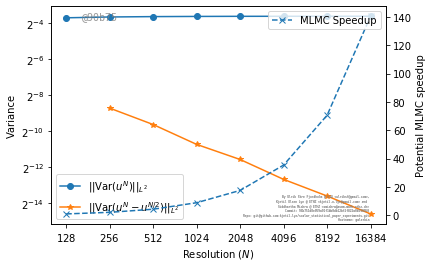

Resolution: 128
Resolution: 256
Resolution: 512
Resolution: 1024
Resolution: 2048
Resolution: 4096
Resolution: 8192
Resolution: 16384






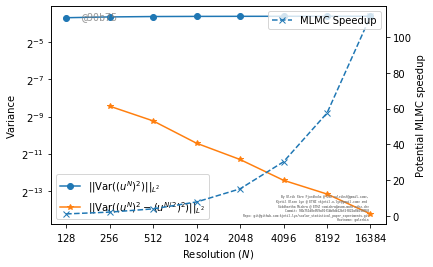

Resolution: 256


In [ ]:
#basename= run_resolutions('shock_location_structure.xml')
basename = 'shock_location_structure_%d/shock_location_structure_0.nc'
#makeConvergenceStudies(basename, 'shock_location', [1,2,3,4,5],
#                       exactSolution = lambda H: exactIntegratedStructureShockLocation(0.2,H))
#plot2Pt(basename, 'shock_location', 1024,0.3)
#plot2Pt(basename, 'shock_location', 1024,0.01)
#makeConvergenceStudy2Pt(basename, 'shock_location')

compute_mean_speedup(basename, "Uncertain shock location")

compute_structure_speedup(basename, "Uncertain shock location")
compute_structure_cube_speedup(basename, "Uncertain shock location")

In [ ]:
x = 0.40
t = 0.2
resolution = 256
alsvinn.run(base_xml='shock_location_structure.xml',
           dimension=[resolution, 1, 1],
           samples=resolution,
           uq=True)

p = 1

K = 256
H = np.linspace(0, K/1024., int(K*resolution/1024))
S = structure('shock_location_structure_0.nc', resolution, H, resolution, p)

plt.plot(H, S, label='Monte Carlo')
plt.plot(H, exactIntegratedStructureShockLocation(0.2, H), '--', label='Exact')
plt.legend()
plt.xlabel('$r$')
plt.ylabel(f'$\\int_{{L^1(D)}}\\int_D |u(x+r)-u(x)|\\; dx\\; d\\mu^{{{t}}}_{{1/{resolution}}}(u)$')

plot_info.showAndSave('structure_shock_location_comparison_single_level')



S_single_point = structure_single_point('shock_location_structure_0.nc', resolution, H, resolution, p, x)

exact_single_point = np.zeros_like(S_single_point)

for i, h in enumerate(H):
    exact_single_point[i] = exactStructureShockLocation(x, t, h)

plt.plot(H, S_single_point, label='Monte Carlo')
plt.plot(H, exact_single_point, '--', label='Exact')
plt.legend()
plt.xlabel('$r$')
plt.ylabel(f'$\\int_{{L^1(D)}}|u({x}+r)-u({x})|\\; d\\mu^{{{t}}}_{{1/{resolution}}}(u)$')

plot_info.showAndSave('structure_single_point_shock_location_comparison_single_level')






S_cube = structure_cube('shock_location_structure_0.nc', resolution, H, resolution, p)

plt.loglog(H, S_cube, label='Monte Carlo')
plt.legend()
plt.xlabel('$r$')
plt.ylabel(f'$\\int_{{L^1(D)}}\\int_0^1\\frac{{1}}{{r}}\\int_{{-r}}^{{r}}|u(x+r)-u(x)|\\; dr\;dxd\\mu^{{{t}}}_{{1/{resolution}}}(u)$')

plot_info.showAndSave('structure_cube_shock_location_comparison_single_level')


In [ ]:

x = 0.5
S_single_point = structure_single_point('shock_location_structure_0.nc', resolution, H, resolution, p, x)

exact_single_point = np.zeros_like(S_single_point)

for i, h in enumerate(H):
    exact_single_point[i] = exactStructureShockLocation(x, t, h)

plt.plot(H, S_single_point, label='Monte Carlo')
plt.plot(H, exact_single_point, '--', label='Exact')
plt.legend()
plt.xlabel('$r$')
plt.ylabel('$\\bar{S}^1_r$')

plot_info.showAndSave('structure_single_point_shock_location_comparison_single_level')


# Brownian motion (H=0.5)

## Configuration files

In [ ]:
%%writefile brownian_motion_structure.xml
<config>
  <fvm>
    <name>
      brownian_motion_structure
    </name>
    <platform>cpu</platform>
    <grid>
      <lowerCorner>0 0 0</lowerCorner>
      <upperCorner>1 0 0</upperCorner>
      <dimension>32 1 1</dimension>
    </grid>
    <boundary>neumann</boundary>
    <flux>godunov</flux>
    <endTime>.2</endTime>
    <equation>burgers</equation>
    <reconstruction>none</reconstruction>
    <cfl>auto</cfl>
    <integrator>auto</integrator>
    <initialData>
      <python>brownian_motion_structure.py</python>

      <parameters>
        <parameter>
          <name>X</name>
          <length>16384</length>
          <values><value>0</value></values>
        </parameter>
      </parameters>
    </initialData>
    
    <writer>
      <basename>brownian_motion_structure</basename>
      <type>netcdf</type>
      <numberOfSaves>1</numberOfSaves>
    </writer>

  </fvm>
  <uq>
    <samples>16384</samples>
    <generator>auto</generator>
    <parameters>
      <parameter>
        <name>X</name>
        <length>16384</length>
        <type>uniform</type>
      </parameter>
    </parameters>
    <stats>
     
    </stats>

  </uq>
</config>

In [ ]:
%%writefile brownian_motion_structure.py
import scipy.stats
def init_global(u, nx, ny, nz, ax, ay, az, bx, by, bz):
    Y = scipy.stats.norm.ppf(X)
    # This uses the fractional brownian motion library at
    # https://github.com/kjetil-lye/fractional_brownian_motion
    u[:,0,0] = fbmpy.fractional_brownian_motion_1d(0.5, nx, Y)[:-1]
    

In [ ]:
basename = run_resolutions('brownian_motion_structure.xml')
makeConvergenceStudies(basename, 'brownian', [1,2,3,4,5])
#estimateAndPlotScalings(basename, 'brownian', 4*4096, [1,2,3], maxH=0.3)
#estimateAndPlotScalings(basename, 'brownian', 4*4096, [1,2,3], maxH=0.15)
#
#estimateAndPlotScalings(basename, 'brownian', 4*4096, [1,2,3], maxH=0.1)
#estimateAndPlotScalings(basename, 'brownian', 4*4096, [1,2,3], maxH=0.05)
#estimateAndPlotScalings(basename, 'brownian', 4*4096, [1,2,3], maxH=0.025)
estimateAndPlotScalings(basename, 'brownian', 4*4096, [1,2,3], maxH=0.01)
#plot2Pt(basename, 'brownian', 1024,0.3)
#plot2Pt(basename, 'brownian', 1024,0.01)

#makeConvergenceStudy2Pt(basename, 'brownian')

compute_mean_speedup(basename, "fBm 0.5")

compute_structure_speedup(basename,  "fBm 0.5")
compute_structure_cube_speedup(basename,  "fBm 0.5")

# Fractional Brownian motion

## Configuration files

In [ ]:
%%writefile fractional_brownian_motion_structure.xml
<config>
  <fvm>
    <name>
      fractional_brownian_motion_structure
    </name>
    <platform>cpu</platform>
    <grid>
      <lowerCorner>0 0 0</lowerCorner>
      <upperCorner>1 0 0</upperCorner>
      <dimension>32 1 1</dimension>
    </grid>
    <boundary>neumann</boundary>
    <flux>godunov</flux>
    <endTime>.2</endTime>
    <equation>burgers</equation>
    <reconstruction>none</reconstruction>
    <cfl>auto</cfl>
    <integrator>auto</integrator>
    <initialData>
      <python>fractional_brownian_motion_structure.py</python>

      <parameters>
        <parameter>
          <name>X</name>
          <length>16384</length>
          <values><value>0</value></values>
        </parameter>
      </parameters>
    </initialData>
    
    <writer>
      <basename>fractional_brownian_motion_structure</basename>
      <type>netcdf</type>
      <numberOfSaves>1</numberOfSaves>
    </writer>

  </fvm>
  <uq>
    <samples>16384</samples>
    <generator>auto</generator>
    <parameters>
      <parameter>
        <name>X</name>
        <length>16384</length>
        <type>uniform</type>
      </parameter>
    </parameters>
    <stats>
     
    </stats>

  </uq>
</config>

In [ ]:
%%writefile fractional_brownian_motion_structure.py
import scipy.stats
def init_global(u, nx, ny, nz, ax, ay, az, bx, by, bz):
    Y = scipy.stats.norm.ppf(X)
    
    # This uses the fractional brownian motion library at
    # https://github.com/kjetil-lye/fractional_brownian_motion
    u[:,0,0] = fbmpy.fractional_brownian_motion_1d(0.01, nx, Y)[:-1]
    

## Runs

In [ ]:
for H in ['0.01']:
    basename = run_resolutions('fractional_brownian_motion_structure.xml')
    estimateAndPlotScalings(basename, 'fractional_%s_' % H, 4*4096, [1,2,3], maxH=0.01)
    #
    makeConvergenceStudies(basename, 'fractional_%s_' % H, [1,2,3])
    
    compute_mean_speedup(basename, f"fBm {H}")

    compute_structure_speedup(basename,  f"fBm {H}")
    compute_structure_cube_speedup(basename,  f"fBm {H}")
    #estimateAndPlotScalings(basename, 'fractional_%s_' % H, 4*4096, [1,2,3], maxH=0.3)
    #estimateAndPlotScalings(basename, 'fractional_%s_' % H, 4*4096, [1,2,3], maxH=0.15)
    #estimateAndPlotScalings(basename, 'fractional_%s_' % H, 4*4096, [1,2,3], maxH=0.1)
    #estimateAndPlotScalings(basename, 'fractional_%s_' % H, 4*4096, [1,2,3], maxH=0.05)
    #estimateAndPlotScalings(basename, 'fractional_%s_' % H, 4*4096, [1,2,3], maxH=0.025)

    
    #plot2Pt(basename, 'fractional_%s_' % H, 1024,0.3)
    #plot2Pt(basename, 'fractional_%s_' % H, 1024,0.01)

    
    #makeConvergenceStudy2Pt(basename, 'fractional_%s_' % H)

# Cubic

In [ ]:
%%writefile fractional_brownian_motion_structure_cubic.xml
<config>
  <fvm>
    <name>
      fractional_brownian_motion_structure_cubic
    </name>
    <platform>cpu</platform>
    <grid>
      <lowerCorner>0 0 0</lowerCorner>
      <upperCorner>1 0 0</upperCorner>
      <dimension>32 1 1</dimension>
    </grid>
    <boundary>neumann</boundary>
    <flux>godunov</flux>
    <endTime>.2</endTime>
    <equation>cubic</equation>
    <reconstruction>none</reconstruction>
    <cfl>auto</cfl>
    <integrator>auto</integrator>
    <initialData>
      <python>fractional_brownian_motion_structure_cubic.py</python>

      <parameters>
        <parameter>
          <name>X</name>
          <length>16384</length>
          <values><value>0</value></values>
        </parameter>
      </parameters>
    </initialData>
    
    <writer>
      <basename>fractional_brownian_motion_structure_cubic</basename>
      <type>netcdf</type>
      <numberOfSaves>1</numberOfSaves>
    </writer>

  </fvm>
  <uq>
    <samples>16384</samples>
    <generator>auto</generator>
    <parameters>
      <parameter>
        <name>X</name>
        <length>16384</length>
        <type>uniform</type>
      </parameter>
    </parameters>
    <stats>
     
    </stats>

  </uq>
</config>

In [ ]:
%%writefile fractional_brownian_motion_structure_cubic.py
import scipy.stats
def init_global(u, nx, ny, nz, ax, ay, az, bx, by, bz):
    Y = scipy.stats.norm.ppf(X)
    
    # This uses the fractional brownian motion library at
    # https://github.com/kjetil-lye/fractional_brownian_motion
    u[:,0,0] = fbmpy.fractional_brownian_motion_1d(0.01, nx, Y)[:-1]
    

In [ ]:
for H in ['0.01']:
    basename = run_resolutions('fractional_brownian_motion_structure_cubic.xml')
    estimateAndPlotScalings(basename, 'fractional_cubic_%s_' % H, 4*4096, [1,2,3], maxH=0.01)
    #
    makeConvergenceStudies(basename, 'fractional_cubic_%s_' % H, [1,2,3])
    compute_mean_speedup(basename, f"cubic fBm {H}")

    compute_structure_speedup(basename,  f"cubic fBm {H}")
    compute_structure_cube_speedup(basename,  f"cubic fBm {H}")
    #estimateAndPlotScalings(basename, 'fractional_%s_' % H, 4*4096, [1,2,3], maxH=0.3)
    #estimateAndPlotScalings(basename, 'fractional_%s_' % H, 4*4096, [1,2,3], maxH=0.15)
    #estimateAndPlotScalings(basename, 'fractional_%s_' % H, 4*4096, [1,2,3], maxH=0.1)
    #estimateAndPlotScalings(basename, 'fractional_%s_' % H, 4*4096, [1,2,3], maxH=0.05)
    #estimateAndPlotScalings(basename, 'fractional_%s_' % H, 4*4096, [1,2,3], maxH=0.025)

    
    #plot2Pt(basename, 'fractional_%s_' % H, 1024,0.3)
    #plot2Pt(basename, 'fractional_%s_' % H, 1024,0.01)

    
    #makeConvergenceStudy2Pt(basename, 'fractional_%s_' % H)

In [ ]:
%%writefile brownian_motion_structure_cubic.xml
<config>
  <fvm>
    <name>
      brownian_motion_structure_cubic
    </name>
    <platform>cpu</platform>
    <grid>
      <lowerCorner>0 0 0</lowerCorner>
      <upperCorner>1 0 0</upperCorner>
      <dimension>32 1 1</dimension>
    </grid>
    <boundary>neumann</boundary>
    <flux>godunov</flux>
    <endTime>.2</endTime>
    <equation>burgers</equation>
    <reconstruction>none</reconstruction>
    <cfl>auto</cfl>
    <integrator>auto</integrator>
    <initialData>
      <python>brownian_motion_structure_cubic.py</python>

      <parameters>
        <parameter>
          <name>X</name>
          <length>16384</length>
          <values><value>0</value></values>
        </parameter>
      </parameters>
    </initialData>
    
    <writer>
      <basename>brownian_motion_structure_cubic</basename>
      <type>netcdf</type>
      <numberOfSaves>1</numberOfSaves>
    </writer>

  </fvm>
  <uq>
    <samples>16384</samples>
    <generator>auto</generator>
    <parameters>
      <parameter>
        <name>X</name>
        <length>16384</length>
        <type>uniform</type>
      </parameter>
    </parameters>
    <stats>
     
    </stats>

  </uq>
</config>

In [ ]:
%%writefile brownian_motion_structure_cubic.py
import scipy.stats
def init_global(u, nx, ny, nz, ax, ay, az, bx, by, bz):
    Y = scipy.stats.norm.ppf(X)
    
    # This uses the fractional brownian motion library at
    # https://github.com/kjetil-lye/fractional_brownian_motion
    u[:,0,0] = fbmpy.fractional_brownian_motion_1d(0.5, nx, Y)[:-1]
    

In [ ]:
basename = run_resolutions('brownian_motion_structure_cubic.xml')
makeConvergenceStudies(basename, 'brownian_cubic', [1,2,3,4,5])
#estimateAndPlotScalings(basename, 'brownian', 4*4096, [1,2,3], maxH=0.3)
#estimateAndPlotScalings(basename, 'brownian', 4*4096, [1,2,3], maxH=0.15)
#
#estimateAndPlotScalings(basename, 'brownian', 4*4096, [1,2,3], maxH=0.1)
#estimateAndPlotScalings(basename, 'brownian', 4*4096, [1,2,3], maxH=0.05)
#estimateAndPlotScalings(basename, 'brownian', 4*4096, [1,2,3], maxH=0.025)
estimateAndPlotScalings(basename, 'brownian_cubic', 4*4096, [1,2,3], maxH=0.01)
#plot2Pt(basename, 'brownian', 1024,0.3)
#plot2Pt(basename, 'brownian', 1024,0.01)

#makeConvergenceStudy2Pt(basename, 'brownian')